This will explore how importance scores from three different methods compare on simulated data.

The simulated data was as follows:
- 1/4th sequences with 1-3 instances of a GATA_disc1 motif embedded (see http://compbio.mit.edu/encode-motifs/ for the PWM); these were labelled 0,1,0
- 1/4rd sequences with 1-3 instances of a TAL1_known1 motif embedded; these were labelled 0,0,1
- 1/4rd sequences with BOTH 1-3 instances of a GATA_disc1 motif AND 1-3 instances of a TAL1_known1 motif; these were labelled 1,1,1
- 1/4rd sequences with no motifs embedded; these were labelled 0,0,0

Scores for all three tasks for sequences that contain both TAL1_known1 and GATA_disc1 motifs are analyzed in this notebook

First, we generate data to analyze. Let's make datasets with the same distribution of motifs as the data that the model was trained on (the model was not trained on this exact data)

In [1]:
#Generate the data. Will install the simdna package if necessary.
try:
    import simdna
except ImportError, e:
    print("installing simdna package")
    !pip install git+git://github.com/kundajelab/simdna.git

#This will produce a warning about embedding a TAL1_known1 motif, which is normal
!./generate_data.sh

Read in the data

In [2]:
import simdna.synthetic as synthetic
tal_gata_filename = "DensityEmbedding_prefix-talgata_motifs-GATA_disc1+TAL1_known1_min-1_max-3_mean-2_zeroProb-0_seqLength-200_numSeqs-1000.simdata.gz"
#read in the data
tal_gata_data = synthetic.read_simdata_file(tal_gata_filename)

Load the keras model and convert the models to the importance-scoring format. We will compare methods of deeplift, gradient\*input and guided backprop\*input.

In [3]:
import deeplift
import deeplift.conversion.keras_conversion as kc
import numpy as np
from deeplift.blobs import NonlinearMxtsMode

#load the keras model
#at the time of writing, this uses keras 1.1.2 and tensorflow dimension ordering
keras_model_weights = "record_2_model_v0CG1_modelWeights.h5"
keras_model_yaml = "record_2_model_v0CG1_modelYaml.yaml"
keras_model = kc.load_keras_model(weights=keras_model_weights,
                                  yaml=keras_model_yaml)

#make various kinds of importance scoring models
deeplift_model, grad_model, guided_backprop_model, guided_backprop_deeplift_model =\
    [kc.convert_sequential_model(
        model=keras_model,
        nonlinear_mxts_mode=nonlinear_mxts_mode) for nonlinear_mxts_mode in
        [NonlinearMxtsMode.DeepLIFT,
         NonlinearMxtsMode.Gradient,
         NonlinearMxtsMode.GuidedBackprop,
         NonlinearMxtsMode.GuidedBackpropDeepLIFT]]


Using TensorFlow backend.


One-hot encode the sequence data

In [4]:
#install the avutils package if it isn't installed
try:
    import avutils
except ImportError, e:
    print("installing avutils package")
    !pip install git+git://github.com/kundajelab/avutils.git

import avutils
import avutils.util

#get one-hot encoded sequence for the tal_gata data
tal_gata_onehot = np.array([avutils.util.seq_to_one_hot(seq) for seq in tal_gata_data.sequences])

Double-check that the conversion happened correctly by making sure both the original keras model and the converted models are giving the same predictions (this is not strictly necessary for computing importance scores)

In [5]:
#make sure predictions are the same as the original model
from deeplift.util import compile_func
deeplift_prediction_func = compile_func([deeplift_model.get_layers()[0].get_activation_vars()],
                                        deeplift_model.get_layers()[-1].get_activation_vars())
original_model_predictions = keras_model.predict(tal_gata_onehot, batch_size=200)
converted_model_predictions = deeplift.util.run_function_in_batches(
                                input_data_list=[tal_gata_onehot],
                                func=deeplift_prediction_func,
                                batch_size=200,
                                progress_update=None)
assert np.max(np.array(converted_model_predictions)-np.array(original_model_predictions)) < 10**-5
tal_gata_predictions = converted_model_predictions

Sort the predictions by confidence, for use later

In [6]:
#taldata predictions sorted by confidence
tal_gata_predictions_sorted = sorted(enumerate(tal_gata_predictions), key=lambda x: -x[1][0])

Compute the importance scores using the three different methods for all three tasks

In [7]:
#set the reference to something with gc content of background
reference = np.array([0.27, 0.23, 0.23, 0.27])[None,None,:]

#compute the importance scores on the sequences
deeplift_func, grad_times_inp_func, guided_backprop_func, guided_backprop_deeplift_func =\
    [model.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-2)
     for model in [deeplift_model, grad_model, guided_backprop_model, guided_backprop_deeplift_model]]

from collections import OrderedDict
method_to_task_to_scores = OrderedDict()
for method_name, score_func in [('deeplift', deeplift_func),
                               ('grad_times_inp', grad_times_inp_func),
                               ('guided_backprop_times_inp', guided_backprop_func),
                               ('guided_backprop_deeplift_times_inp', guided_backprop_deeplift_func)]:
    method_to_task_to_scores[method_name] = {}
    for task_idx in [0,1,2]:
        scores = np.array(score_func(
                    task_idx=task_idx,
                    input_data_list=[tal_gata_onehot],
                    input_references_list=[reference],
                    batch_size=200,
                    progress_update=None))
        assert scores.shape[-1]==4
        scores = np.sum(scores, axis=-1) #sum over each position
        method_to_task_to_scores[method_name][task_idx] = scores

Compile the coordinates of the embedded motifs

In [8]:
motif_locations = {'GATA_disc1':[], 'TAL1_known1':[]}
for embeddings in tal_gata_data.embeddings:
    for motif in motif_locations:
        motif_locations[motif].append([])
    for embedding in embeddings:
        motif_locations[embedding.what.getDescription()][-1]\
                       .append((embedding.startPos, embedding.startPos+len(embedding.what)))

Visualize the scores at the sequence predicted most confidently. Cyan boxes indicate the ground-truth locations of the inserted TAL1_known1 motifs, red boxes indicate the ground-truth locations of the inserted GATA_disc1 motifs

deeplift


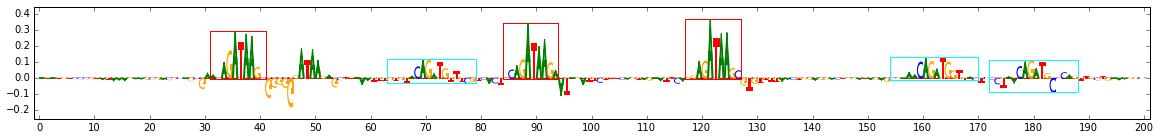

grad_times_inp


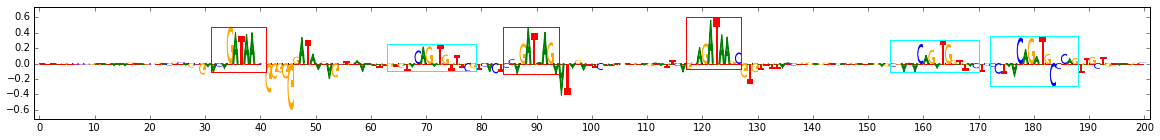

guided_backprop_times_inp


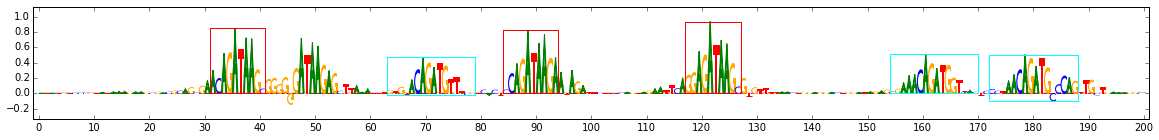

guided_backprop_deeplift_times_inp


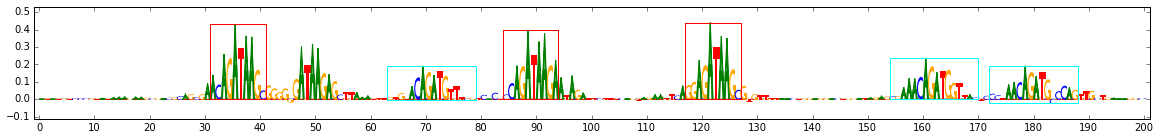

In [9]:
#visualize scores + ground-truth locations of motifs
%matplotlib inline
from deeplift.visualization import viz_sequence
reload(viz_sequence)

sorted_idx = 0
idx = tal_gata_predictions_sorted[sorted_idx][0]

for method_name in method_to_task_to_scores:
    scores = method_to_task_to_scores[method_name][0]
    scores_for_idx = scores[idx]
    original_onehot = tal_gata_onehot[idx]
    scores_for_idx = original_onehot*scores_for_idx[:,None]
    print(method_name)
    highlight = {'red':motif_locations['GATA_disc1'][idx],
                 'cyan':motif_locations['TAL1_known1'][idx]}
    viz_sequence.plot_weights(scores_for_idx, subticks_frequency=10, highlight=highlight)